# Interactive Clustering Exploration Lab
**CYBERSEC 520: Hands-On Clustering & Anomaly Detection**

## Lab Objectives
- **Explore** how different parameters affect clustering
- **Compare** K-Means, GMM, and DBSCAN algorithms
- **Analyze** real cybersecurity datasets
- **Discover** optimal cluster numbers for different scenarios

## Group Activity Structure
**Groups of 3-4 students** | **Online students: Partner up or work solo**

### Activity Timeline (90 minutes Max):
1. **Setup & Synthetic Data** (15 min)
2. **Parameter Exploration** (20 min)
3. **Real Data Analysis** (40 min)
4. **Group Comparisons** (15 min)

---

## Setup and Imports

In [35]:
# Essential imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import KElbowVisualizer
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Plotting setup
plt.rcParams['figure.figsize'] = (12, 8)
sns.set_palette("husl")

print("Setup complete! Ready to explore clustering!")

Setup complete! Ready to explore clustering!


In [36]:
# Mount Google Drive for dataset access
from google.colab import drive
drive.mount('/content/drive')

print("Google Drive mounted successfully!")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive mounted successfully!


---

## Part 1: Synthetic Data Generation

### Run the Following cell

In [37]:
def generate_clustering_data(n_samples, n_centers, cluster_std,
                            anomaly_fraction, noise_level):
    """
    Generate synthetic data for clustering experiments

    Parameters:
    - n_samples: Total number of data points
    - n_centers: Number of true clusters
    - cluster_std: Standard deviation of clusters (tightness)
    - anomaly_fraction: Fraction of points to make anomalous
    - noise_level: Amount of random noise to add
    """
    # Generate main clusters
    normal_samples = int(n_samples * (1 - anomaly_fraction))
    X_normal, y_true = make_blobs(n_samples=normal_samples, centers=n_centers,
                                  cluster_std=cluster_std)

    # Add noise to normal data
    X_normal += np.random.normal(0, noise_level, X_normal.shape)

    # Generate anomalous points
    anomaly_samples = int(n_samples * anomaly_fraction)
    if anomaly_samples > 0:
        # Anomalies are far from clusters
        anomaly_range = [X_normal.min() - 3, X_normal.max() + 3]
        X_anomaly = np.random.uniform(anomaly_range[0], anomaly_range[1],
                                     (anomaly_samples, 2))

        # Combine normal and anomalous data
        X = np.vstack([X_normal, X_anomaly])
        labels = np.hstack([np.zeros(normal_samples), np.ones(anomaly_samples)])
        cluster_labels = np.hstack([y_true, [-1] * anomaly_samples])
    else:
        X = X_normal
        labels = np.zeros(normal_samples)
        cluster_labels = y_true
        print("No anomalies generated.")

    return X, labels, cluster_labels

def plot_data(X, labels, title="Generated Data"):
    """Quick plotting function"""
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', alpha=0.7)
    plt.title(title, fontweight='bold', fontsize=14)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.colorbar(scatter)
    plt.grid(True, alpha=0.3)
    plt.show()

print("Data generation functions ready!")

Data generation functions ready!


### Experiment 1: Play with Parameters!

**GROUP TASK:** Try different parameter combinations and observe how they affect clustering.

**Parameters to Experiment With:**
- `n_centers`: 2, 3, 5, 8 (true number of clusters)
- `cluster_std`: 0.5, 1.0, 2.0, 3.0 (cluster tightness)
- `anomaly_fraction`: 0.0, 0.05, 0.15, 0.25 (percentage of outliers)
- `noise_level`: 0.0, 0.1, 0.5, 1.0 (background noise)


Generated data with 2 true clusters
Data shape: (800, 2)
Anomalies: 12 (1.5%)


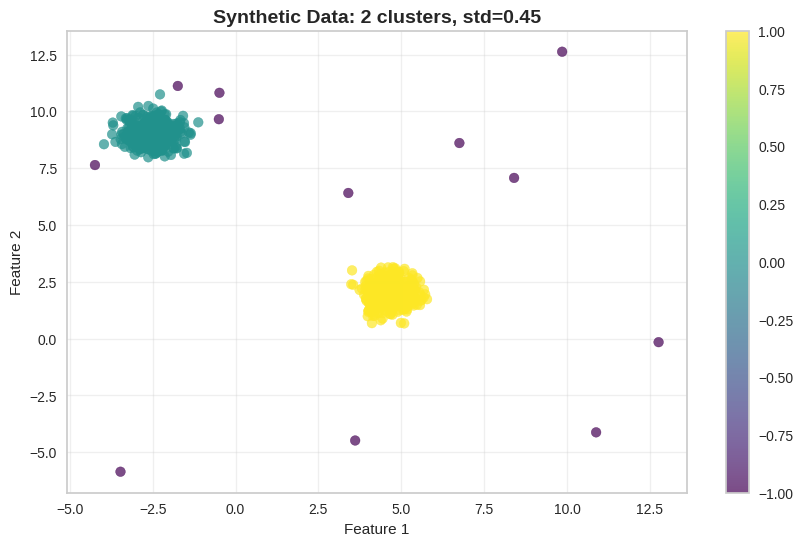


 DISCUSS WITH YOUR GROUP:
1. How does cluster_std affect the data visualization?
2. What happens when anomaly_fraction increases?
3. How does noise_level impact cluster separation?


In [38]:
# EXPERIMENT 1: Modify these parameters and run multiple times!
# Try different combinations and discuss with your group

# MODIFY THESE PARAMETERS:
n_centers = 2          # True number of clusters (try: 2, 3, 5, 8)
cluster_std = 0.45      # Cluster tightness (try: 0.5, 1.0, 2.0, 3.0)
anomaly_fraction = 0.015 # Fraction of outliers (try: 0.0, 0.05, 0.15, 0.25)
noise_level = 0.0      # Background noise (try: 0.0, 0.1, 0.5, 1.0)

# Generate and visualize data
X, anomaly_labels, true_clusters = generate_clustering_data(
    n_samples=800, n_centers=n_centers, cluster_std=cluster_std,
    anomaly_fraction=anomaly_fraction, noise_level=noise_level
)

print(f"Generated data with {n_centers} true clusters")
print(f"Data shape: {X.shape}")
print(f"Anomalies: {np.sum(anomaly_labels == 1)} ({anomaly_fraction*100:.1f}%)")

# Plot the generated data
plot_data(X, true_clusters, f"Synthetic Data: {n_centers} clusters, std={cluster_std}")

# GROUP DISCUSSION QUESTIONS:
print("\n DISCUSS WITH YOUR GROUP:")
print("1. How does cluster_std affect the data visualization?")
print("2. What happens when anomaly_fraction increases?")
print("3. How does noise_level impact cluster separation?")

---

## Part 2: Quick Clustering Algorithm Comparison

### Compare K-Means, GMM, and DBSCAN on Your Data

In [62]:
def find_optimal_clusters(X, max_k=10, method='both'):
    """Find optimal number of clusters using elbow and silhouette methods"""

    if method in ['elbow', 'both']:
        # Elbow Method
        plt.figure(figsize=(15, 5))

        plt.subplot(1, 2, 1)
        model = KMeans(random_state=42)
        visualizer = KElbowVisualizer(model, k=(2, max_k), timings=False)
        visualizer.fit(X)
        visualizer.draw()
        elbow_k = visualizer.elbow_value_
        plt.title('Elbow Method for Optimal k', fontweight='bold')

        if method == 'both':
            plt.subplot(1, 2, 2)

    if method in ['silhouette', 'both']:
        # Silhouette Method
        if method != 'both':
            plt.figure(figsize=(8, 5))

        k_range = range(2, max_k + 1)
        silhouette_scores = []

        for k in k_range:
            kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
            cluster_labels = kmeans.fit_predict(X)
            silhouette_avg = silhouette_score(X, cluster_labels)
            silhouette_scores.append(silhouette_avg)

        plt.plot(k_range, silhouette_scores, 'ro-', linewidth=2, markersize=8)
        plt.xlabel('Number of clusters (k)')
        plt.ylabel('Silhouette Score')
        plt.title('Silhouette Analysis for Optimal k', fontweight='bold')
        plt.grid(True, alpha=0.3)

        optimal_k_sil = k_range[np.argmax(silhouette_scores)]
        max_silhouette = max(silhouette_scores)

        plt.axvline(x=optimal_k_sil, color='red', linestyle='--',
                   label=f'Optimal k={optimal_k_sil} (score={max_silhouette:.3f})')
        plt.legend()

    plt.tight_layout()
    plt.show()

    if method == 'both':
        print(f"Elbow method suggests: k = {elbow_k}")
        print(f"Silhouette method suggests: k = {optimal_k_sil}")
        return elbow_k, optimal_k_sil
    elif method == 'silhouette':
        print(f"Silhouette method suggests: k = {optimal_k_sil}")
        return optimal_k_sil
    else:
        print(f"Elbow method suggests: k = {elbow_k}")
        return elbow_k

def compare_clustering_algorithms(X, k=4):
    """Compare K-Means, GMM, and DBSCAN"""

    fig, axes = plt.subplots(2, 3, figsize=(18, 12))

    # Original Data
    axes[0, 0].scatter(X[:, 0], X[:, 1], alpha=0.7, s=50)
    axes[0, 0].set_title('Original Data', fontweight='bold')
    axes[0, 0].grid(True, alpha=0.3)

    # K-Means
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans_labels = kmeans.fit_predict(X)
    silhouette_kmeans = silhouette_score(X, kmeans_labels)

    scatter = axes[0, 1].scatter(X[:, 0], X[:, 1], c=kmeans_labels, cmap='viridis', alpha=0.7)
    axes[0, 1].scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1],
                      c='red', marker='x', s=200, linewidths=3)
    axes[0, 1].set_title(f'K-Means (k={k})\nSilhouette: {silhouette_kmeans:.3f}', fontweight='bold')
    axes[0, 1].grid(True, alpha=0.3)

    # GMM
    gmm = GaussianMixture(n_components=k, random_state=42)
    gmm_labels = gmm.fit_predict(X)
    silhouette_gmm = silhouette_score(X, gmm_labels)

    axes[0, 2].scatter(X[:, 0], X[:, 1], c=gmm_labels, cmap='viridis', alpha=0.7)
    axes[0, 2].set_title(f'GMM (k={k})\nSilhouette: {silhouette_gmm:.3f}', fontweight='bold')
    axes[0, 2].grid(True, alpha=0.3)

    # DBSCAN with different parameters
    eps_values = [0.3, 0.5, 1.0]
    min_samples = 5

    for i, eps in enumerate(eps_values):
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        dbscan_labels = dbscan.fit_predict(X)

        n_clusters_db = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
        n_noise = list(dbscan_labels).count(-1)

        if len(set(dbscan_labels)) > 1:
            silhouette_db = silhouette_score(X, dbscan_labels) if n_clusters_db > 1 else 0
        else:
            silhouette_db = 0

        axes[1, i].scatter(X[:, 0], X[:, 1], c=dbscan_labels, cmap='viridis', alpha=0.7)
        axes[1, i].set_title(f'DBSCAN (eps={eps})\nClusters: {n_clusters_db}, Noise: {n_noise}\nSilhouette: {silhouette_db:.3f}',
                           fontweight='bold')
        axes[1, i].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Summary
    print(f"\n ALGORITHM COMPARISON SUMMARY:")
    print(f"K-Means (k={k}): Silhouette = {silhouette_kmeans:.3f}")
    print(f"GMM (k={k}): Silhouette = {silhouette_gmm:.3f}")
    print(f"DBSCAN: Try different eps values to find optimal clustering")

    return {
        'kmeans': {'labels': kmeans_labels, 'silhouette': silhouette_kmeans},
        'gmm': {'labels': gmm_labels, 'silhouette': silhouette_gmm}
    }

print("Clustering comparison functions ready!")

Clustering comparison functions ready!


### Experiment 2: Find the Optimal Number of Clusters

**GROUP TASK:** Use your generated data to find the optimal number of clusters.

Finding optimal clusters for data with 2 true clusters...
Your current parameters: std=0.45, anomalies=0.015, noise=0.0


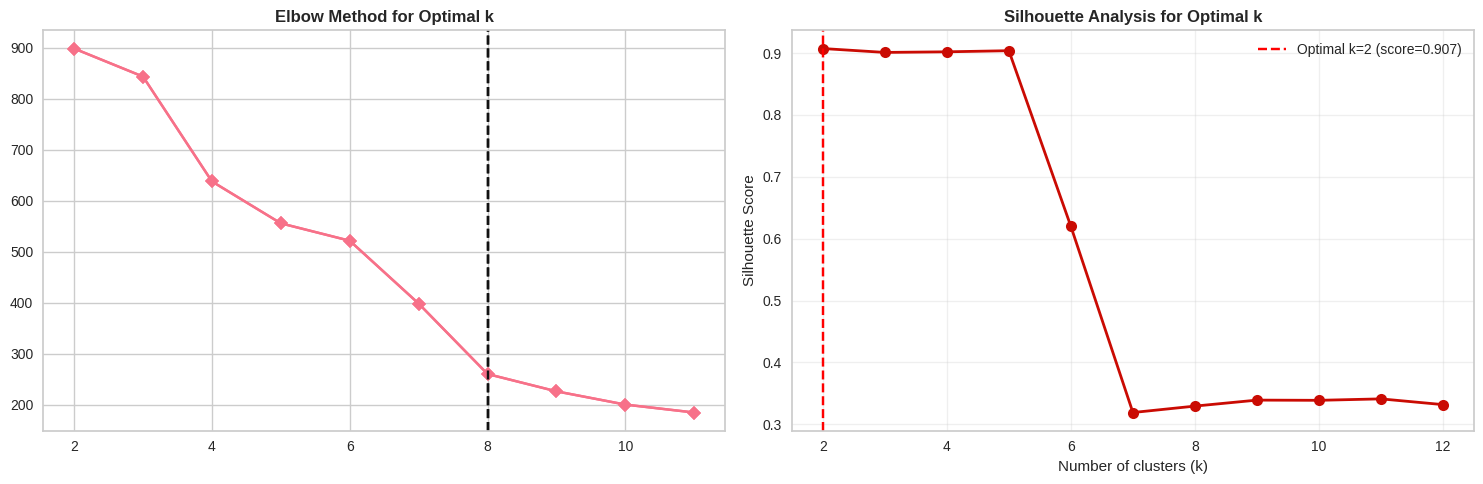

Elbow method suggests: k = 8
Silhouette method suggests: k = 2

RESULTS:
True clusters: 2
Elbow method: 8
Silhouette method: 2

 DISCUSS WITH YOUR GROUP:
1. Do the methods agree on the optimal k?
2. How close are they to the true number of clusters?
3. What factors might cause differences?


In [63]:
# EXPERIMENT 2: Find optimal clusters for your data

print(f"Finding optimal clusters for data with {n_centers} true clusters...")
print(f"Your current parameters: std={cluster_std}, anomalies={anomaly_fraction}, noise={noise_level}")

# Find optimal number of clusters
elbow_k, silhouette_k = find_optimal_clusters(X, max_k=12)

print(f"\nRESULTS:")
print(f"True clusters: {n_centers}")
print(f"Elbow method: {elbow_k}")
print(f"Silhouette method: {silhouette_k}")

# GROUP DISCUSSION:
print("\n DISCUSS WITH YOUR GROUP:")
print("1. Do the methods agree on the optimal k?")
print("2. How close are they to the true number of clusters?")
print("3. What factors might cause differences?")

### Experiment 3: Comparing Algorithms

**GROUP TASK:** Compare how different algorithms handle your data.

Comparing algorithms with k=2...


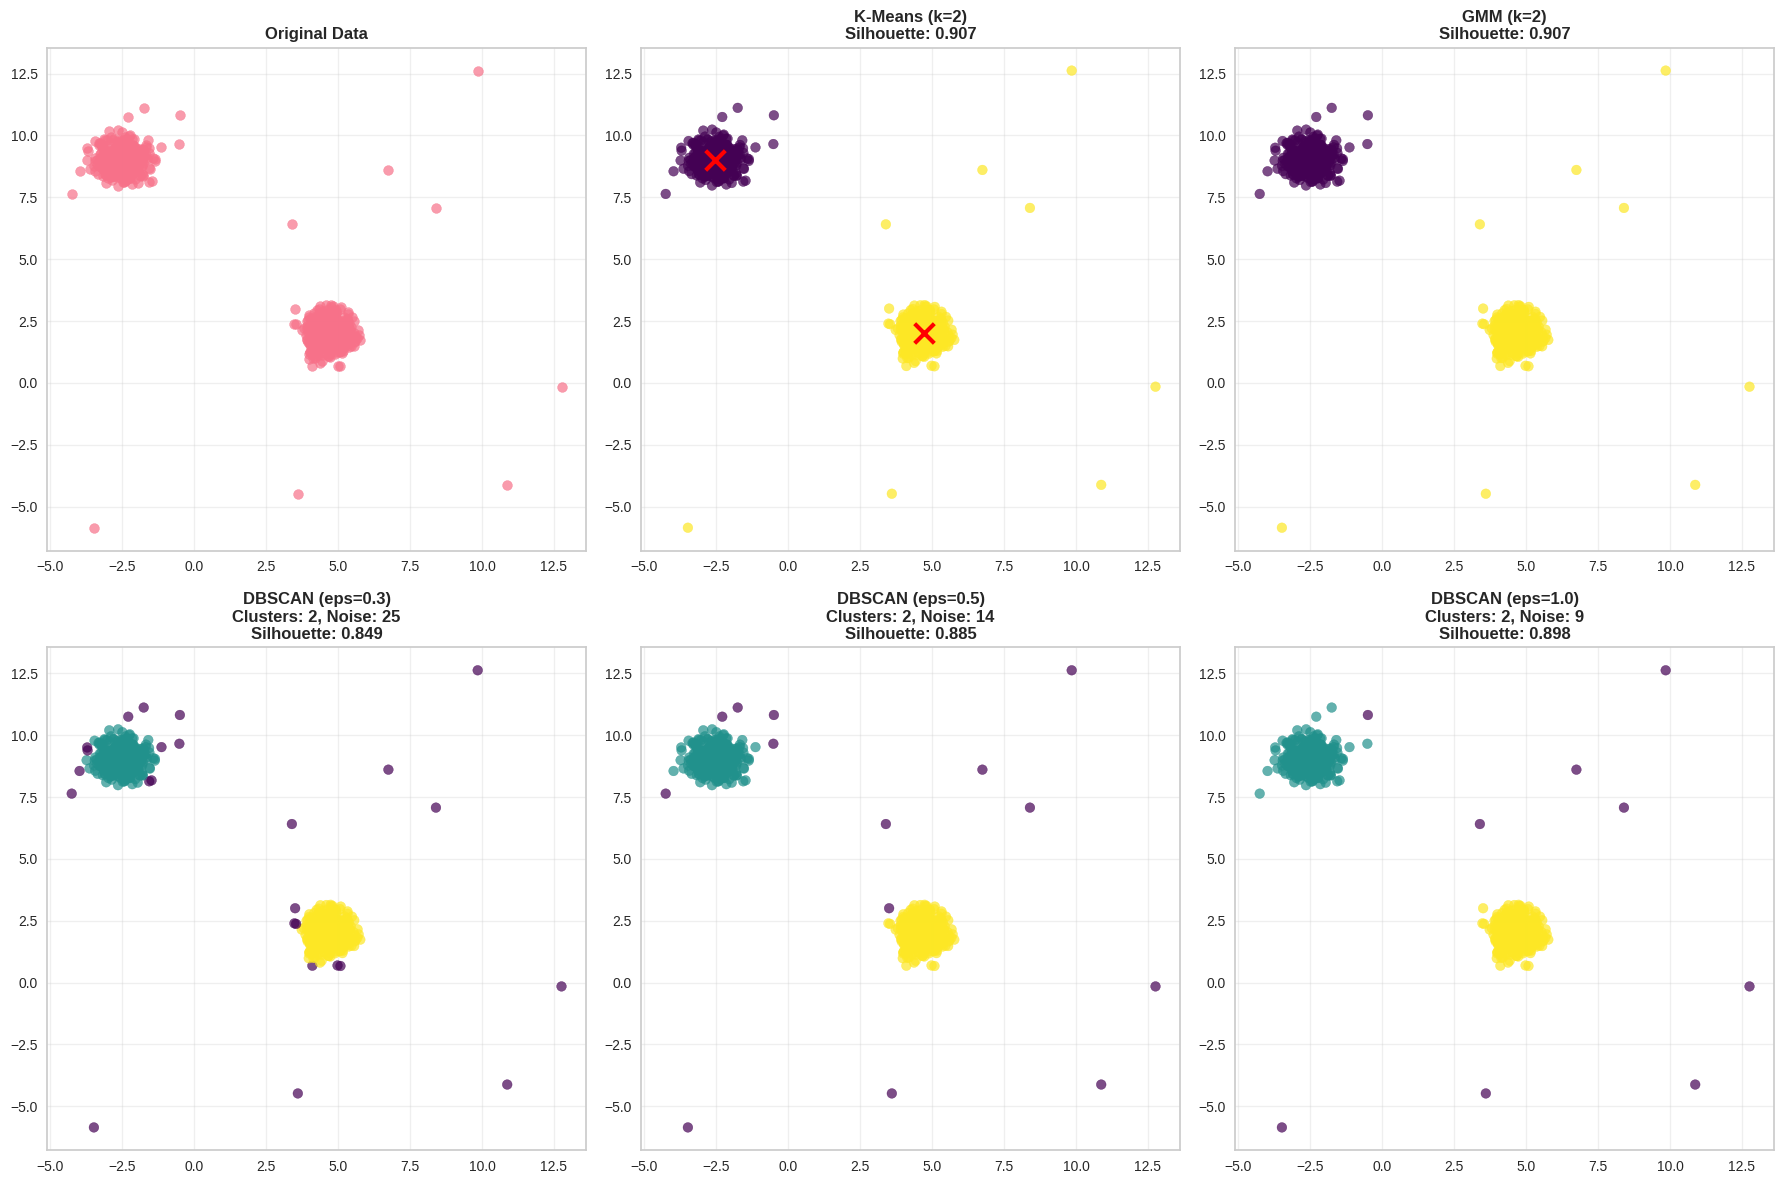


 ALGORITHM COMPARISON SUMMARY:
K-Means (k=2): Silhouette = 0.907
GMM (k=2): Silhouette = 0.907
DBSCAN: Try different eps values to find optimal clustering

 Try different k values by changing 'test_k' above
Suggested values: 2, 2, 3, 4

 DISCUSS WITH YOUR GROUP:
1. Which algorithm performs best on your data?
2. How does DBSCAN handle noise/outliers differently?
3. When might you prefer GMM over K-Means?


In [64]:
# EXPERIMENT 3: Compare clustering algorithms

# Use the optimal k found above (or experiment with different values)
test_k = 2 # Gaurav and the group changed the number to 2, based on the previous result

print(f"Comparing algorithms with k={test_k}...")

results = compare_clustering_algorithms(X, k=test_k)

# EXPERIMENT: Try different k values!
print(f"\n Try different k values by changing 'test_k' above")
print(f"Suggested values: {max(2, n_centers-1)}, {n_centers}, {n_centers+1}, {n_centers+2}")

# GROUP DISCUSSION:
print("\n DISCUSS WITH YOUR GROUP:")
print("1. Which algorithm performs best on your data?")
print("2. How does DBSCAN handle noise/outliers differently?")
print("3. When might you prefer GMM over K-Means?")

---

## Part 3: Real Cybersecurity Data Exploration

### Load and Analyze CIC-IDS2017 Dataset

In [42]:
def load_cybersec_data(file_path, sample_size=2000, focus_benign=True):
    """Load and preprocess cybersecurity dataset"""
    try:
        print(f"Loading data from: {file_path}")
        data = pd.read_csv(file_path)
        print(f"Original shape: {data.shape}")

        if ' Label' in data.columns:
            print(f"Labels found: {data[' Label'].value_counts().to_dict()}")

            if focus_benign:
                # Focus only on benign traffic for clustering
                data_benign = data[data[' Label'] == 'BENIGN'].copy()
                print(f"Filtered to benign traffic: {data_benign.shape[0]} samples")
                data = data_benign

        # Select key features
        feature_cols = [
            ' Flow Duration', ' Total Fwd Packets', ' Total Backward Packets',
            ' Fwd Packet Length Mean', ' Bwd Packet Length Mean',
            ' Flow Bytes/s', ' Flow Packets/s', ' Fwd Packets/s',
            ' Average Packet Size', ' Fwd Segment Size Avg'
        ]

        available_features = [col for col in feature_cols if col in data.columns]
        print(f"🔧 Using {len(available_features)} features: {available_features[:5]}...")

        # Clean and preprocess
        features_df = data[available_features].copy()
        features_df = features_df.replace([np.inf, -np.inf], np.nan)
        features_df = features_df.dropna()


        # Sample if too large
        if len(features_df) > sample_size:
            features_df = features_df.sample(n=sample_size, random_state=42)
            print(f"Sampled to {sample_size} points")

        # Scale features
        scaler = StandardScaler()
        features_scaled = scaler.fit_transform(features_df)

        return features_scaled, features_df.columns.tolist(), len(data)

    except Exception as e:
        print(f"Error loading data: {e}")
        return None, None, None

# Available datasets - UPDATE THESE PATHS!  These are the path for my datasets, yours may vary.
datasets = {
    'Monday': '/content/drive/MyDrive/CYBERSEC 520/Inclass9Sept/Monday-WorkingHours.pcap_ISCX.csv',
    'Tuesday': '/content/drive/MyDrive/CYBERSEC 520/Inclass9Sept/Tuesday-WorkingHours.pcap_ISCX.csv',
    'Wednesday': '/content/drive/MyDrive/CYBERSEC 520/Inclass9Sept/Wednesday-workingHours.pcap_ISCX.csv',
    'Thursday_morning': '/content/drive/MyDrive/CYBERSEC 520/Inclass9Sept/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv',
    'Thursday_afternoon': '/content/drive/MyDrive/CYBERSEC 520/Inclass9Sept/Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv',
    'Friday_DDOS': '/content/drive/MyDrive/CYBERSEC 520/Inclass9Sept/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv',
    'Friday_PortScan': '/content/drive/MyDrive/CYBERSEC 520/Inclass9Sept/Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv',
    'Friday_morning': '/content/drive/MyDrive/CYBERSEC 520/Inclass9Sept/Friday-WorkingHours-Morning.pcap_ISCX.csv'
}

print("Real data loading functions ready!")
print("Remember to update the file paths above to match your Google Drive structure!")

Real data loading functions ready!
Remember to update the file paths above to match your Google Drive structure!


# Challenge: Real Data

## How Well can you classify real data.  

In [59]:
# TODO: Simulate streaming data scenario
# HINT: Process data in small batches
# HINT: Update clustering model incrementally
# HINT: Track performance over time

import numpy as np
from sklearn.cluster import KMeans
import warnings

# Ignore n initialization warning
warnings.filterwarnings("ignore", category=FutureWarning, module='sklearn.cluster._kmeans')

print("Challenge 3: Streaming Anomaly Detection")
print("Simulate real-time processing of network traffic")

if 'X_real' not in locals() or X_real is None:
    print("Real data (X_real) not loaded, run old cells again")
else:
    batch_size = 100
    n_samples = X_real.shape[0]
    n_batches = n_samples // batch_size

    try:
        k_clusters = silhouette_k_real
    except NameError:
        k_clusters = 2

    print(f"Processing {n_samples} samples in {n_batches} batches of {batch_size} each")
    print(f"Cluster model will use k={k_clusters}")

    print("Initializing the model")
    initial_batch = X_real[:batch_size]

    streaming_kmeans = KMeans(n_clusters=k_clusters, random_state=42, n_init=10)
    streaming_kmeans.fit(initial_batch)

    distances = streaming_kmeans.transform(initial_batch).min(axis=1)
    anomaly_threshold = np.percentile(distances, 95)

    print(f"Model trained on initial {len(initial_batch)} samples")
    print(f"Anomaly distance threshold set to: {anomaly_threshold:.4f}")

    print("Starting stream simulation ---")
    all_data_seen = initial_batch.copy()
    total_anomalies_found = 0

    for i in range(1, n_batches):
        start_index = i * batch_size
        end_index = (i + 1) * batch_size
        current_batch = X_real[start_index:end_index]

        batch_distances = streaming_kmeans.transform(current_batch).min(axis=1)

        anomalies_in_batch = np.sum(batch_distances > anomaly_threshold)
        total_anomalies_found += anomalies_in_batch

        print(f"Batch {i+1}/{n_batches}: processed {len(current_batch)} records. found {anomalies_in_batch} potential anomalies.")

        all_data_seen = np.vstack([all_data_seen, current_batch])

        streaming_kmeans.fit(all_data_seen)

    print("Simulation is now complete ---")
    print(f"Total samples processed: {len(all_data_seen):,}")
    print(f"Total anomalies detected: {total_anomalies_found}")
    anomaly_rate = (total_anomalies_found / len(all_data_seen)) * 100
    print(f"Overall anomaly rate: {anomaly_rate:.2f}%")

Challenge 3: Streaming Anomaly Detection
Simulate real-time processing of network traffic
Processing 1500 samples in 15 batches of 100 each
Cluster model will use k=2
Initializing the model
Model trained on initial 100 samples
Anomaly distance threshold set to: 2.9721
Starting stream simulation ---
Batch 2/15: processed 100 records. found 5 potential anomalies.
Batch 3/15: processed 100 records. found 12 potential anomalies.
Batch 4/15: processed 100 records. found 21 potential anomalies.
Batch 5/15: processed 100 records. found 11 potential anomalies.
Batch 6/15: processed 100 records. found 11 potential anomalies.
Batch 7/15: processed 100 records. found 9 potential anomalies.
Batch 8/15: processed 100 records. found 8 potential anomalies.
Batch 9/15: processed 100 records. found 10 potential anomalies.
Batch 10/15: processed 100 records. found 11 potential anomalies.
Batch 11/15: processed 100 records. found 17 potential anomalies.
Batch 12/15: processed 100 records. found 20 potent

# Lab Wrap-up and Reflection

## **Final Discussion Questions**:

Discuss these questions with your partner and be prepared to share with the class:

1. **Algorithm Selection**: Based on your experiments, which clustering algorithm would you recommend for:
   - A real-time SOC environment?
   - Offline threat hunting?
   - Unknown attack discovery?

2. **Parameter Sensitivity**: How sensitive were the algorithms to parameter changes?
   - Which algorithm was most robust?
   - What would you do if parameters needed frequent tuning?

3. **Real-world Deployment**: What challenges do you anticipate when deploying these methods in production?
   - How would you handle concept drift (changing network behavior)?
   - How would you validate results without ground truth labels?
   - How would you reduce false positive rates?

4. **Next Steps**: What improvements or extensions would you suggest?
   - Additional features to consider?
   - Hybrid approaches?
   - Integration with existing security tools?

## **Lab Summary**

Fill in your results:

| Method | Optimal Parameters | Silhouette Score |
|--------|-------------------|------------------|
| K-means | k = _2__ | _0.907__ |
| GMM | k = _2__ | _0.907__ |
| DBSCAN | eps = _1__, min_samples = _5__ | _0.898__ |

**Key Insight**: Our group understood  that different clustering algorithms are suited for different tasks in the cybersecurity field.While K-Means and GMM are effective for identifying distinct, spherical clusters, DB scan is better at handling noise which is efficient for anomaly detection.________________________________

**Biggest Challenge**: ____________Biggest challenge was the streaming anomaly detection simulation as it involved processing traffic data into 100 records at a time,while updating the K-means model incrementally.____________________

**Most Surprising Finding**: It was the effectiveness of the model as it detected 171 total anomalies from 1500 processed samples,leading to a anomaly rate of 11.40% which tells us that simple clustering approach can be very effective in identifying a significant volume of anomalous behavior.________________________________

---

## **Next Steps**

**Next Week**: Deep learning approaches for cybersecurity

**Great work on completing the clustering lab!**

# Group members: Gaurav Suryawanshi, Mitali Joshi, Aditya Srikar Konduri, Sejal Nayak